In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import calendar
import concurrent.futures

### Extract sensor ids of interest

In [27]:
response = requests.get("https://data.sensor.community/airrohr/v1/filter/country=DE,AT&type=SDS011")
sensors_dict = json.loads(response.content.decode('utf-8'))

In [28]:
sensors_of_interest = [{"sensor_id": sensor_measurement["sensor"]["id"], 
                        "lon": sensor_measurement["location"]["longitude"], 
                        "lat": sensor_measurement["location"]["latitude"]} for sensor_measurement in sensors_dict]
sensors_df = pd.DataFrame(sensors_of_interest)

In [29]:
sensors_df.to_csv("/mnt/data/processed/sensor_community_ids_de_at_sds011.csv")

# clipping to aoi is done in QGIS

### Extracting archive values for sensors of interest

In [85]:
def generate_urls(year: int, sensor_id: int, sensor_type: str = "sds011"):
    urls = []
    suffix = "csv" if year in [2021, 2022] else "csv.gz"
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        for day in range(1, days_in_month + 1):
            formatted_date = f"{year}-{month:02d}-{day:02d}"
            url = f"http://archive.sensor.community/{year}/{formatted_date}/{formatted_date}_{sensor_type}_sensor_{sensor_id}.{suffix}"
            urls.append(url)
    return urls

def process_sensor_data(url, sid):
    try:
        df = pd.read_csv(url, sep=";")
        p1_value = df["P1"].mean()
        p2_value = df["P2"].mean()
        date = url.split("/")[-2]
        return (sid, date, p1_value, p2_value)
    except Exception as e:
        return None

In [100]:
sensors_of_interest_df  = pd.read_csv("/mnt/data/processed/sensor_community_ids_aoi_sds011.csv")
data_tup_ls = []

for i, item in sensors_of_interest_df.iterrows():
    sid = int(item["sensor_id"])
    lat = item["lat"]
    lon = item["lon"]
    url_list = generate_urls(2020, sid)

    for url in url_list:
        result = process_sensor_data(url, sid)
        if result is not None:
            data_tup_ls.append(result)

    break

<Axes: >

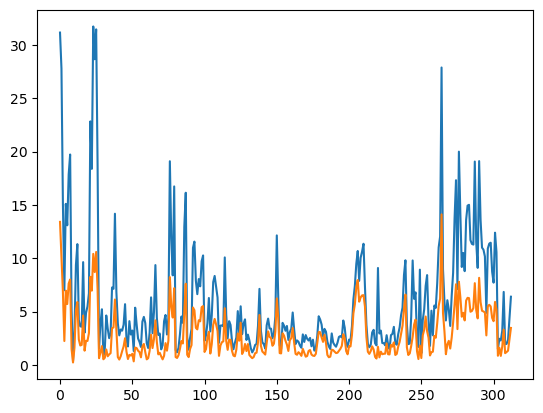

In [101]:
df = pd.DataFrame(data_tup_ls, columns=["sid", "date", "P1", "P2"])
df["P1"].plot()
df["P2"].plot()

In [102]:
df

,sid,date,P1,P2
0,37151,2020-01-01,31.162016,13.409803
1,37151,2020-01-02,27.785293,10.051180
2,37151,2020-01-03,15.125733,6.822339
3,37151,2020-01-04,7.010389,2.236484
4,37151,2020-01-05,15.098546,6.962013
...,...,...,...,...
308,37151,2020-12-27,1.948625,1.098837
309,37151,2020-12-28,1.968955,1.205923
310,37151,2020-12-29,2.349049,1.330989
311,37151,2020-12-30,4.408035,2.389795
